# Bibliotecas


In [ ]:
import pandas as pd #lida com os dataframes
import numpy as np #Biblioteca matematica
import seaborn as sns #Graficos complexos
import matplotlib.pyplot as plt #Graficos base
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# Importando os dados

In [ ]:
df = pd.read_csv('iot_telemetry_data.csv')

# Analíse exploratoria

In [ ]:
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


## Features

- "ts" = Tempo da leitura (Float)
- "device" = Nome do dispositivo que fez a leitura (string)
- "CO" = Nivel de Moóxido de Carbono (Float)
- "humidity" = % de Humidade do ar (Float)
- "light" = Se luz foi ou não detectada (Bolean)
- "lpg" = gás liquefeito de petróleo (Float)
- "motion" = se movimento foi detectado ou não (Bolean)
- "smoke" = Nivel de fumaça no ambiente (Float)
- "temperature" = temperatura em farenheit (Float)



## Tamanho do dataframe

In [ ]:
df.shape

(405184, 9)

## Análise de valores nulos

Não há valores nulos no dataset

In [ ]:
print('Quantidade de valores nulos:')
for i in df.columns:
  na = df[i].isna().sum()
  print(i,':', na)

number of NA values
ts : 0
device : 0
co : 0
humidity : 0
light : 0
lpg : 0
motion : 0
smoke : 0
temp : 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


## Analisando a variação na temperatura e humidade
Podemos observar que os dispositivos estão sobre postos e com muito ruído

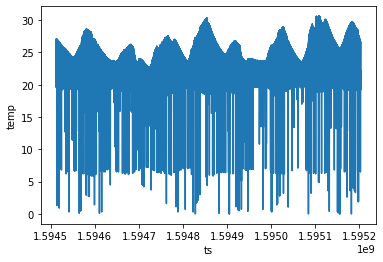

In [ ]:
sns.lineplot(data=df, x="ts", y="temp")
plt.show()

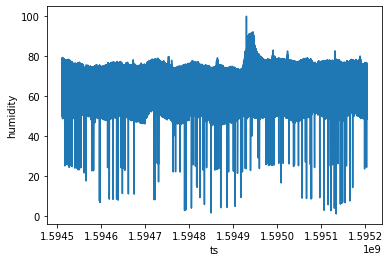

In [ ]:
sns.lineplot(data=df, x="ts", y="humidity")
plt.show()

## Olhando os dispostivos separadamente

Análise individual dos dispositivos a fim de analisar a diferença da variação das variaveis ao longo do tempo 



In [ ]:
df.device.replace({'1c:bf:ce:15:ec:4d': 1, 
                   'b8:27:eb:bf:9d:51': 2, 
                   '00:0f:00:70:91:0a': 3}
                  ,inplace=True)

# Criando a variável target


In [ ]:
df['status'] = df.device
df.status.replace({1: 1, 
                   2: 0, 
                   3: 0},
                  inplace=True) 
df.status.replace({1: 1, #highly variable temperature and humidity
                   2: 0, #stable conditions, warmer and dryer
                   3: 0},inplace=True) #stable conditions, cooler and more humid

In [ ]:
Df_dispositivo_1 = df[df['device']==1].copy()
Df_dispositivo_2 = df[df['device']==2].copy()
Df_dispositivo_3 = df[df['device']==3].copy()

## Reduzindo a amostragem do dataframe:

Reamostragem dos dados para um intervalo maior tempo a fim de reduzir a quantidade de dados redundantes

In [ ]:
# cortando o dataframe

Df_dispositivo_1['intervalo'] = pd.qcut(Df_dispositivo_1.ts,
                                        424,labels=False)
Df_dispositivo_1 = Df_dispositivo_1.groupby(Df_dispositivo_1['intervalo']).mean()

Df_dispositivo_2['intervalo'] = pd.qcut(Df_dispositivo_2.ts, 424,labels=False)
Df_dispositivo_2 = Df_dispositivo_2.groupby(Df_dispositivo_2['intervalo']).mean()

Df_dispositivo_3['intervalo'] = pd.qcut(Df_dispositivo_3.ts, 424,labels=False)
Df_dispositivo_3 = Df_dispositivo_3.groupby(Df_dispositivo_3['intervalo']).mean()

# Juntando o dataframe
df_media = Df_dispositivo_1.append(Df_dispositivo_2.append(Df_dispositivo_3))

In [ ]:
df_media

,ts,device,co,humidity,light,lpg,motion,smoke,temp,status
intervalo,,,,,,,,,,
0,1.594513e+09,1,0.004352,78.080400,1.000000,0.006964,0.000,0.018461,26.999200,1
1,1.594514e+09,1,0.004282,77.792400,1.000000,0.006883,0.000,0.018231,26.804000,1
2,1.594516e+09,1,0.004237,77.367600,1.000000,0.006831,0.004,0.018084,26.796400,1
3,1.594517e+09,1,0.004126,76.936800,1.000000,0.006701,0.000,0.017716,26.666401,1
4,1.594519e+09,1,0.004118,77.014401,1.000000,0.006691,0.000,0.017690,26.445200,1
...,...,...,...,...,...,...,...,...,...,...
419,1.595196e+09,3,0.003349,74.998864,0.000000,0.005762,0.000,0.015078,19.213637,0
420,1.595198e+09,3,0.003522,75.392775,0.000000,0.005976,0.000,0.015676,19.135361,0
421,1.595199e+09,3,0.003637,75.163257,0.000000,0.006117,0.000,0.016072,19.217424,0


## separando os dados de validação

Separando os dados para serem utilizados na validação do modelo

In [ ]:
validacao = df_media.sample(frac = 0.1).copy()
df_media.drop(validacao.index, inplace=True)

## Variação ao longo do tempo do dispositivo 1

### Grafico da temperatura do dispositivo 1 ao longo do tempo 

O intuito do grafico é mostrar a variação entre os valores em curtos espaços de tempo

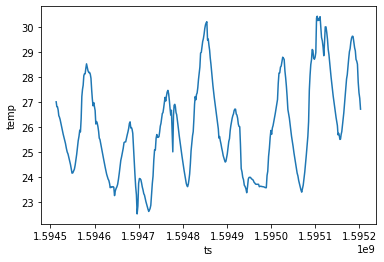

In [ ]:
sns.lineplot(data=Df_dispositivo_1, x="ts", y="temp")#highly variable temperature and humidity
plt.show()

### Grafico da umidade do dispositivo 1 ao longo do tempo 

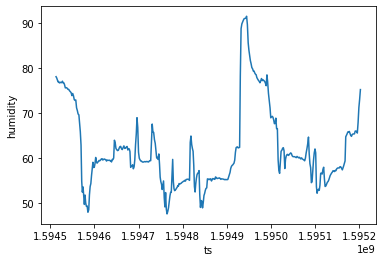

In [ ]:
sns.lineplot(data=Df_dispositivo_1, x="ts", y="humidity")#highly variable temperature and humidity
plt.show()

## Variação ao longo do tempo do dispositivo 2

### Grafico da temperatura do dispositivo 2 ao longo do tempo 

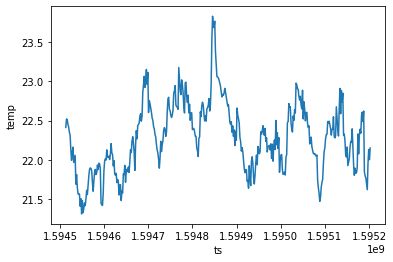

In [ ]:
sns.lineplot(data=Df_dispositivo_2, x="ts", y="temp")#stable conditions, warmer and dryer
plt.show()

### Grafico da umidade do dispositivo 2 ao longo do tempo 

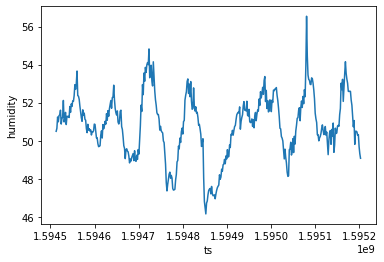

In [ ]:
sns.lineplot(data=Df_dispositivo_2, x="ts", y="humidity") #stable conditions, warmer and dryer
plt.show()

## Variação ao longo do tempo do dispositivo 3

### Grafico da temperatura do dispositivo 3 ao longo do tempo 

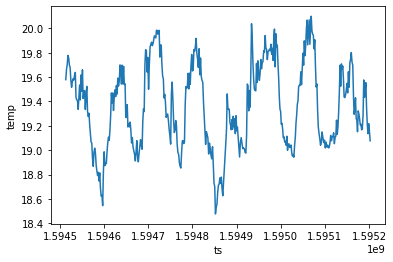

In [ ]:
sns.lineplot(data=Df_dispositivo_3, x="ts", y="temp") #stable conditions, cooler and more humid
plt.show()

### Grafico da umidade do dispositivo 3 ao longo do tempo 

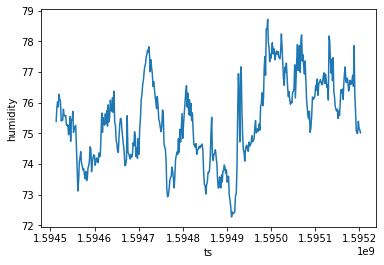

In [ ]:
sns.lineplot(data=Df_dispositivo_3, x="ts", y="humidity") #stable conditions, cooler and more humid
plt.show()

## Comparando os dispositivos:

### Analisando a diferença entre as variações nos dispositivos 

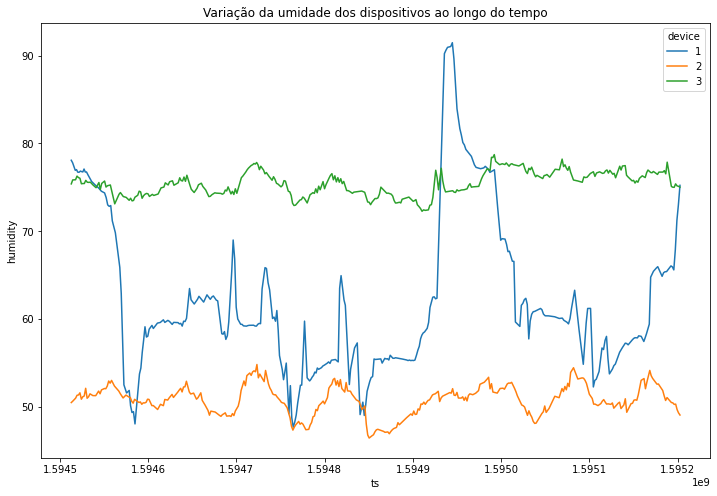

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_media, x="ts", y="humidity", hue='device',palette="tab10") 
plt.title('Variação da umidade dos dispositivos ao longo do tempo')
plt.show()

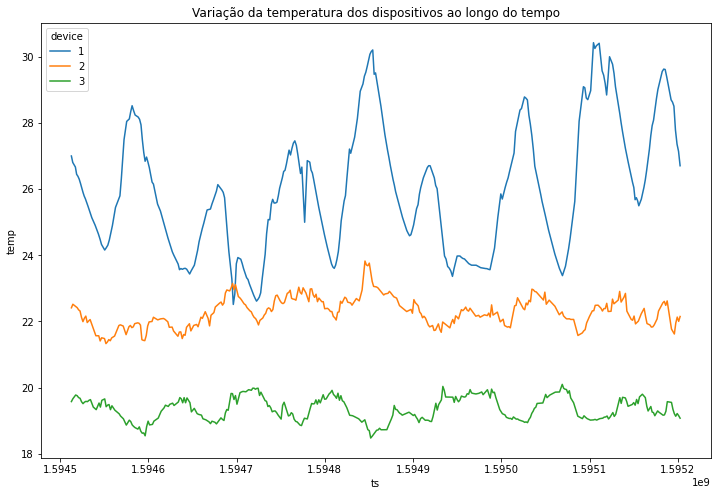

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_media, x="ts", y="temp", hue='device',palette="tab10") 
plt.title('Variação da temperatura dos dispositivos ao longo do tempo')
plt.show()

### Comparação da variancia entre os dispositivos:

In [ ]:
var_humidade_disp=[Df_dispositivo_1.humidity.var(),
                   Df_dispositivo_2.humidity.var(),
                   Df_dispositivo_3.humidity.var()]

var_temp_disp = [Df_dispositivo_1.temp.var(),
                 Df_dispositivo_2.temp.var(),
                 Df_dispositivo_3.temp.var()]
                 
nomes = ['Dispositivo 1',
         'Dispositivo 2',
         'Dispositivo 3']

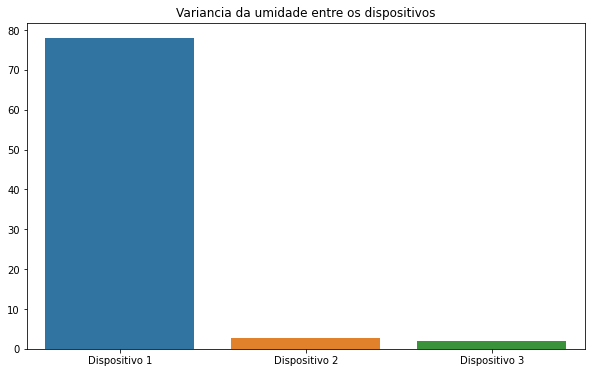

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=nomes, y=var_humidade_disp)
plt.title('Variancia da umidade entre os dispositivos')
plt.show()

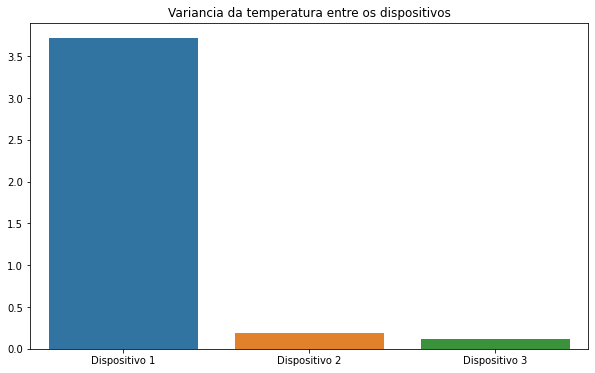

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=nomes, y=var_temp_disp)
plt.title('Variancia da temperatura entre os dispositivos')
plt.show()

## Analisando a distribuição da coluna luz:

In [ ]:
valores_distribuição = [(Df_dispositivo_1.light[
            Df_dispositivo_1['light']==True].sum())
          /Df_dispositivo_1.shape[0]*100,
           (Df_dispositivo_2.light[
           Df_dispositivo_2['light']==True].sum())
          /Df_dispositivo_2.shape[0]*100,
           (Df_dispositivo_3.light[
           Df_dispositivo_3['light']==True].sum())
          /Df_dispositivo_3.shape[0]*100
          ]

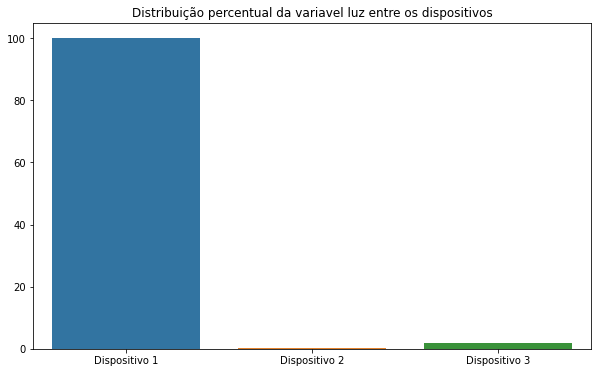

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=nomes, y=valores_distribuição)
plt.title('Distribuição percentual da variavel luz entre os dispositivos')
plt.show()

# Correlação geral entre as colunas

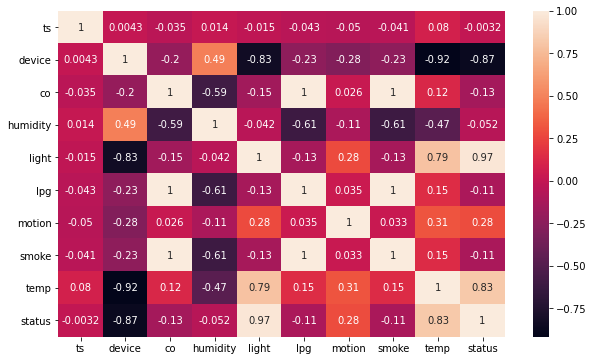

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df_media.corr(), annot=True)
plt.show()

# Feature engineering


Transformando os dados
- Removendo colunas com baixa correlação
- Criando novas features com correlação alta 


In [ ]:
def Tranformation(df):
  df['humidity*temp^2'] = df['humidity']*(df['temp']*df['temp'])
  df.drop(['ts','device'], axis=1,inplace=True)
  df.drop(['motion','light'], axis=1,inplace=True)
  df['gases'] = df['co'] + df['lpg'] + df['smoke']
  df.drop(['co','lpg','smoke'], axis=1,inplace=True)
  return df

In [ ]:
df_media = Tranformation(df_media)

## Olhando a correlação com as novas variavéis

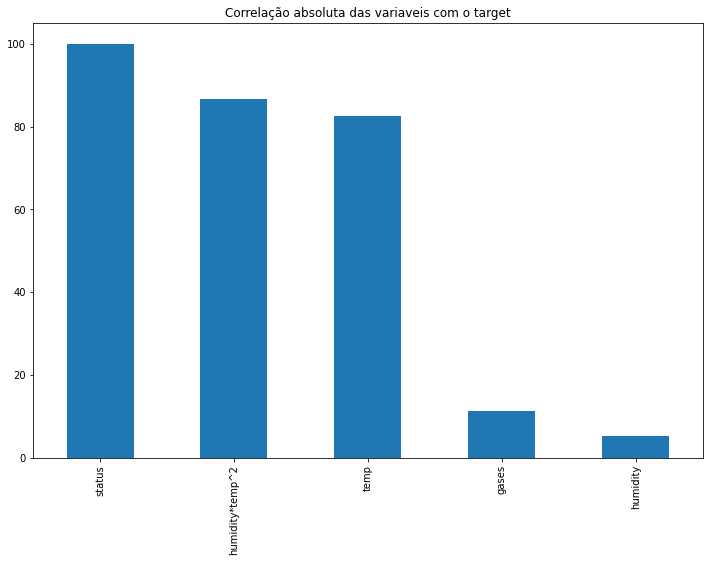

In [ ]:
df_corr = df_media.corr().status
df_corr = df_corr*100
df_corr[df_corr < 0] = df_corr[df_corr < 0] * -1
plt.figure(figsize=(12,8))
df_corr.sort_values(ascending=False).plot(kind = "bar", title = "Correlação absoluta das variaveis com o target")
plt.show()

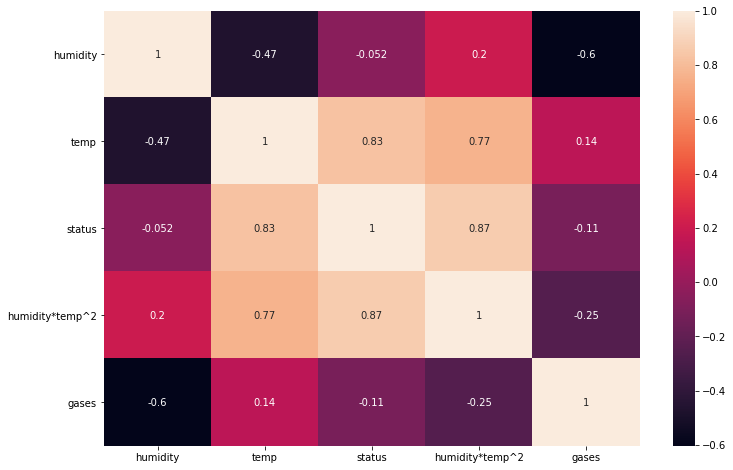

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_media.corr(), annot=True)
plt.show()

# Criando o modelo para predição:


## Quebrando os dados em treino e teste:

In [ ]:
X = df_media.drop('status', axis=1)
y = df_media['status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Treinando o modelo:

In [ ]:
clf = LogisticRegression(C=1,random_state=42,max_iter=600)
clf.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Calculando o score com validação cruzada

In [ ]:
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())

0.9913978494623656


### Gráfico da acurácia:
 

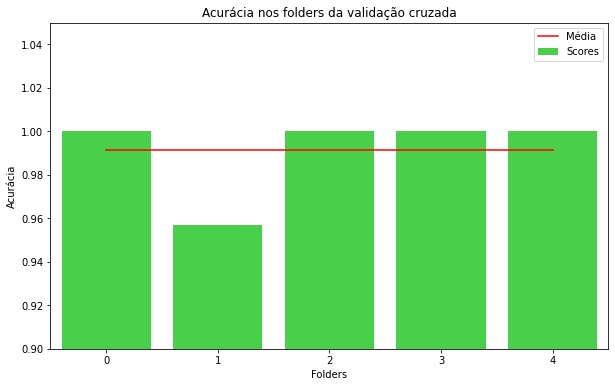

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x=list(range(5)), y=scores.mean(),color='r', label='Média')
sns.barplot(x=list(range(5)), y=scores,color=[0.2,0.9,0.2,0.7], label='Scores')
plt.legend(loc='upper right')
plt.ylim(ymin=0.9)
plt.xlabel('Folders')
plt.ylabel('Acurácia')
plt.title('Acurácia nos folders da validação cruzada')
plt.show()


## Analisando a matrix de confusão:

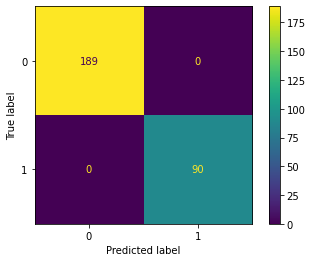

In [ ]:
plot_confusion_matrix(clf, X_test, y_test,values_format='.3g')
plt.show()

# Validando com o conjunto de validação:

## Transformando os dados e separando a variavel target

In [ ]:
validacao = Tranformation(validacao)

In [ ]:
Xv = validacao.drop('status', axis=1)
yv = validacao['status']

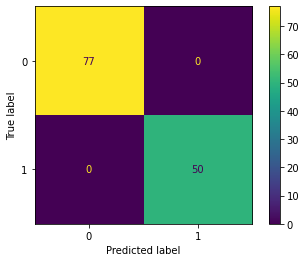

In [ ]:
plot_confusion_matrix(clf, Xv, yv,values_format='.3g')
plt.show()